# **트레이딩 전략과 구현 6장 | 삼중창 매매**
**[Markdown Wiki](https://ko.wikipedia.org/wiki/%EC%9C%84%ED%82%A4%EB%B0%B1%EA%B3%BC:TeX_%EB%AC%B8%EB%B2%95)** | **[Markdown Editor](http://www.hostmath.com/)**
- **시장조류, 시장파도(오실레이터 |과매수 신호), 진입기술(추세 추종형 지표)**
- **<span style="color:orange">시장 지표들이 서로다른 신호</span>** 를 보낼 때, **이들을 종합하여 정확한 매매시점** 을 구성

| 구분   |  발생 시점  |    지표     |
|:-----:|:---------:|:----------:|
|추세    | 동행 또는 후행| 이동평균 (Moving Averages) |
|       |            | 이동평균 수렴 및 확산 (MACD)  |
|       |            | MACD 히스토그램             |
|       |            | 방향성 시스템 (the Direction System) |
|       |            | 거래량 균형 지표 (On Balance Volume, OBV) |
|       |            | 누적분산 지표 (Accumulation/ Distributuin, AD) |
|========|============|============================================|
|오실레이터| 선행 또는 동행| 스토캐스틱 (Stochastic) |
|        |           | 변화율 (Rate of Change) |
|        |           | 평활화된 변화율 (Smoothed RoC) |
|        |           | 모멘텀 (Momentum)     |
|        |           | 상대강도지수 (Relative Strength Index, RSI)|
|        |           | 엘더레이 (Elder-Ray) |
|        |           | 강도지수 (The Force Index) |
|        |           | 윌리엄스 (Williams %R) |
|        |           | 상대가격 변동폭 (the Commodity Channel Index) |
|========|============|============================================|
|기타지표  | 선행 또는 동행 | 신고점-신저점 지수 (New High-New Low Index) |
|        |             | 풋-콜 비율 (the Put-Call Ratio)    |
|        |             | 상승하락 지수 (the Advanced/ Decline Index, A/D) |
|        |             | 트레이더 지수 (the Trader's Index, TRIN) |

# **1 첫번째 창 - Market Tide(시장조류|장기적 상승, 하락추세)**
- 시장의 **상승 및 하락 추세** 여부를 판단한다
- 시장에서 **매수, 매도, 관망** 의 3가지 선택지 중, **<span style="color:orange">한 개를 제거</span>** 하는 기법

## **01 데이터 불러오기**
loading the Naver Stock Price Table

In [1]:
import os
import pandas as pd
file_save = "data/boillingerNC.csv"
if os.path.isfile(file_save):
    data_df = pd.read_csv(file_save)
    data_df['Date'] = pd.to_datetime(data_df['Date']) # datetime 포맷 변경
    data_df = data_df.set_index('Date')
else:
    from FinanceDataReader import DataReader as fdr
    data_df = fdr("036570", "2018-01-01")
    data_df.to_csv(file_save)

data_df.columns = [_.lower() for _ in data_df.columns]
data_raw = data_df.copy() # Backuped the Table
data_df.tail(3)

open    high     low   close  volume    change
Date                                                        
2021-07-30  838000  846000  823000  824000   79822 -0.020214
2021-08-02  833000  833000  810000  824000   68330  0.000000
2021-08-03  827000  828000  803000  810000   89905 -0.016990

## **02 지수 이동평균 (Exponential Moving Averages)**
- EWM (지수 이동평균의 계산) : **[Pandas EWM 이동평균 구현방식](https://www.openaitrading.com/python-pandas-%EC%9D%B4%EB%8F%99%ED%8F%89%EA%B7%A0-%EA%B5%AC%ED%95%98%EA%B8%B0/)**
- MACD (Moving Average Convergence Divergence) : 12주(분기) 와 26주(반기) EWM 의 차이를 계산
- 시장의 신호는 **<span style="color:orange">MACD 의 기울기</span>** 를 활용하여 시장의 상승, 하락 추세를 파악
$$ EMA = P_{today} \times K + EMA_{yesterday} \times (1-K) $$
$$ MACD히스토그램 = MACD선 - 신호선 $$

In [2]:
# .iterrows() : DataFrame 의 index 순서로 Series 출력
for idx, val in data_df.iloc[:2,:2].iterrows(): 
    print(f"{idx},\n {type(val)}, \n{val} \n")

2018-01-02 00:00:00,
 <class 'pandas.core.series.Series'>, 
open    448000
high    452500
Name: 2018-01-02 00:00:00, dtype: int64 

2018-01-03 00:00:00,
 <class 'pandas.core.series.Series'>, 
open    441500
high    446500
Name: 2018-01-03 00:00:00, dtype: int64 



In [3]:
ema60    = data_df.close.ewm(span=60).mean()  # 종가의 지수 이동평균 : 12주
ema130   = data_df.close.ewm(span=130).mean() # 종가의 지수 이동평균 : 26주
macd     = ema60 - ema130                     # MACD 그리기 (12주, 26주 이동평균의 차이)
signal   = macd.ewm(span=45).mean()           # 신호선(MACD의 9주 지수 이동평균)
macdhist = macd - signal                      # MACD 히스토그램

data_df = data_df.assign(
    ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()
data_df.head(3)

open    high     low   close  volume    change         ema130  \
Date                                                                          
2018-01-02  448000  452500  442000  446500  121955 -0.002235  446500.000000   
2018-01-03  441500  446500  432000  435000  234234 -0.025756  440705.769231   
2018-01-04  438500  438500  422000  422500  284220 -0.028736  434543.579022   

                    ema60        macd     signal   macdhist  
Date                                                         
2018-01-02  446500.000000    0.000000   0.000000   0.000000  
2018-01-03  440654.166667  -51.602564 -26.374644 -25.227920  
2018-01-04  434399.962966 -143.616056 -67.204602 -76.411453

## **03 Visualization**
- [OHLC Chart in Python Matplotlib](https://towardsdatascience.com/basics-of-ohlc-charts-with-pythons-matplotlib-56d0e745a5be)

결과값 시각화 작업

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading ... Visualization Modules
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
for _ in font_list_check:
    font_counts = [f  for f in font_list_check if _ in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: print(f"found : {_}"); plt.rc('font', family=_); break 

import numpy as np
# ohlc = data_df[['open','high','low','close', 'volume', "ema130"]].copy()
ohlc = data_df.copy()
ohlc = ohlc.reset_index()
ohlc.head(3)

found : D2Coding


Date    open    high     low   close  volume    change         ema130  \
0 2018-01-02  448000  452500  442000  446500  121955 -0.002235  446500.000000   
1 2018-01-03  441500  446500  432000  435000  234234 -0.025756  440705.769231   
2 2018-01-04  438500  438500  422000  422500  284220 -0.028736  434543.579022   

           ema60        macd     signal   macdhist  
0  446500.000000    0.000000   0.000000   0.000000  
1  440654.166667  -51.602564 -26.374644 -25.227920  
2  434399.962966 -143.616056 -67.204602 -76.411453

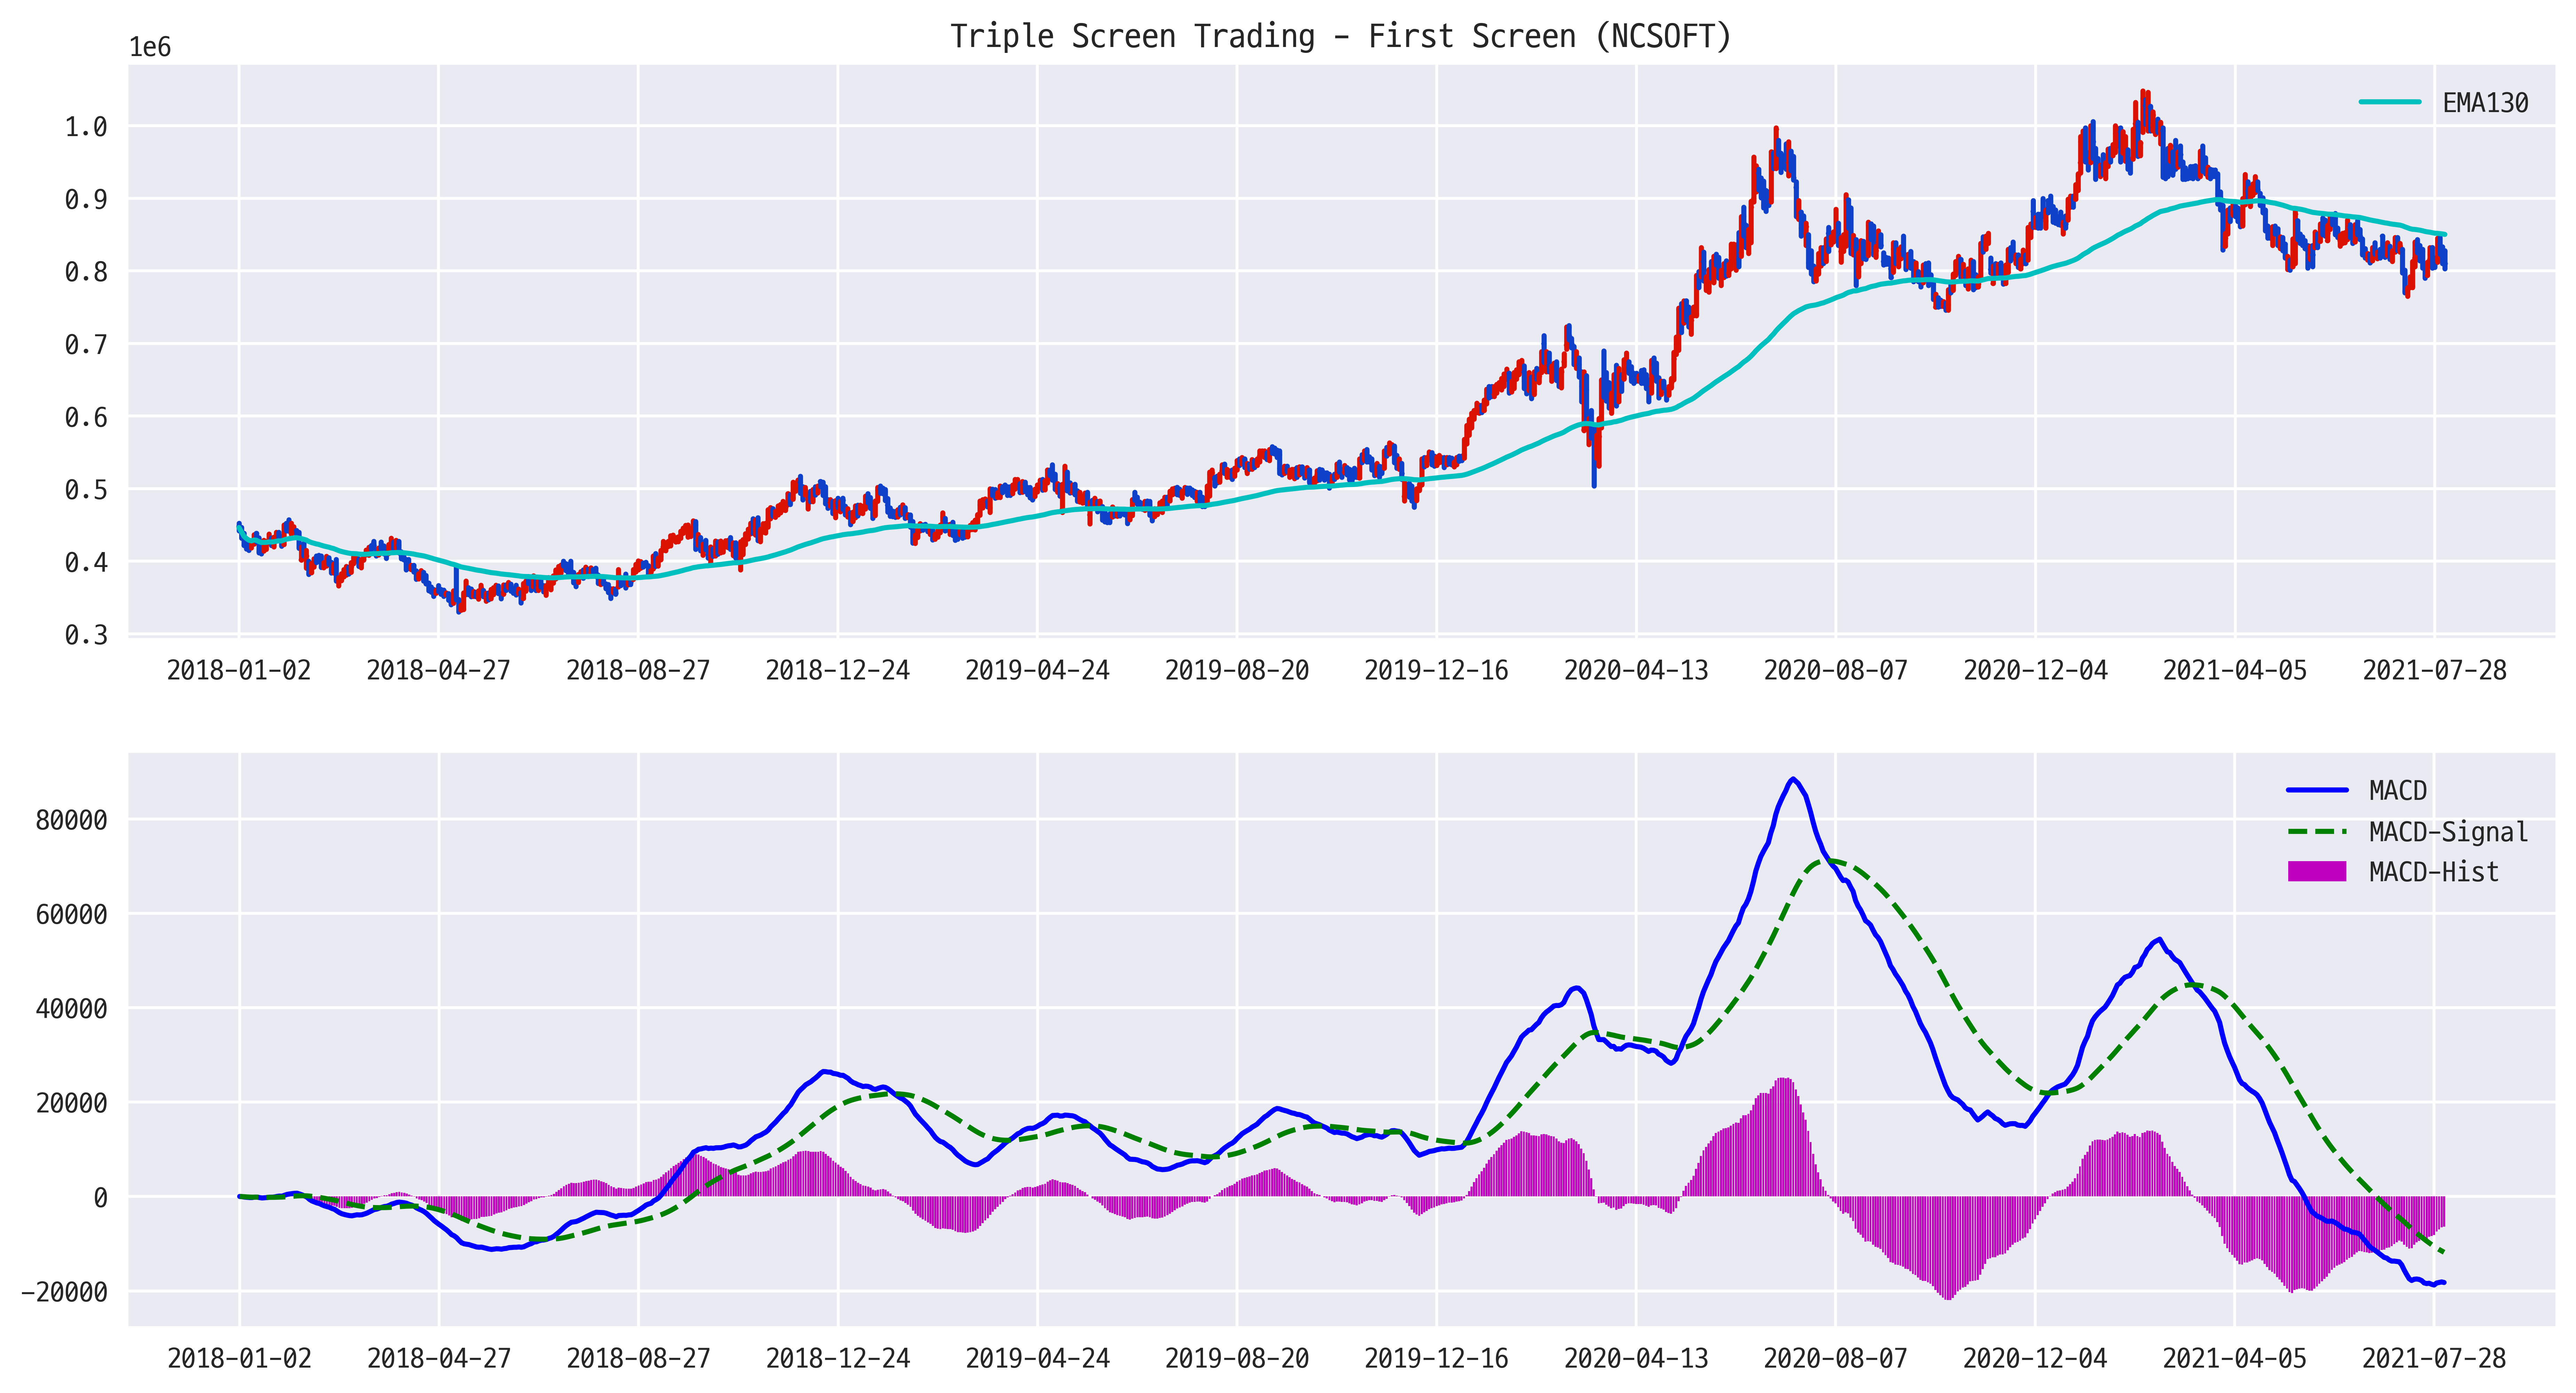

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (15.0, 8.0) # plt.figure(figsize=(16, 7))

# Chart 1 : OHLC Chart
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - First Screen (NCSOFT)')
plt.grid(True)

# ohlc Chart 그리기
x = np.arange(0, len(ohlc))
for _, val in ohlc.iterrows():
    if val['close'] > val['open']: color = "#db1102" # 종가 상승
    else: color = "#0e40c9"                          # 종가 하락
    p1.plot([ x[_], x[_]], [val['low'], val['high']], color=color)     # High, Low Marker
    p1.plot([ x[_], x[_]-.1], [val['open'], val['open']], color=color) # Open Marker
    p1.plot([ x[_], x[_]+.1], [val['close'], val['close']], color=color) # close Marker

# ema130 Chart 추가하기
p1.plot(ohlc['ema130'], color='c', label='EMA130')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')

# Chart 2 : Signal Chart
p2 = plt.subplot(2, 1, 2)
plt.bar(ohlc.index, ohlc['macdhist'], color='m', label='MACD-Hist')
plt.plot(ohlc['macd'], color='b', label='MACD')
plt.plot(ohlc['signal'], 'g--', label='MACD-Signal')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')
plt.grid(True)
plt.show()

# **2 두번째 창 - Market Wave(시장파도 | 박스권 시장의 성격 분석)**
## **01 오실레이터 (oscillator) 데이터 활용하기**
- Stockastic 은 George Lane 이 개발할 대중화된 오실레이터 이다
- 대체로 **<span style="color:orange">박스권 매매</span>** 에서 효과적으로 작동한다
- 위 단점을 보완하기 위해, 장기 추세 신호를 함께 활용한다

$$ \%K (빠른선) = \dfrac{C_{today} + L_{n}}{H_{n} + L_{n}} \times 100 $$

- $ C_{today} $ : 금일의 종가
- $ H_{n} $ : 선정된 기간의 고점
- $ L_{n} $ : 선정된 기간의 저점
- $ n $ : 트레이더에 의해 선정된 기준 기간

$$ \%D (느린선) = \dfrac{C_{today} + L_{n} 의 3일간 합계 }{H_{n} + L_{n} 의 3일간 합계} \times 100 $$

In [6]:
data_df.head(3)

open    high     low   close  volume    change         ema130  \
Date                                                                          
2018-01-02  448000  452500  442000  446500  121955 -0.002235  446500.000000   
2018-01-03  441500  446500  432000  435000  234234 -0.025756  440705.769231   
2018-01-04  438500  438500  422000  422500  284220 -0.028736  434543.579022   

                    ema60        macd     signal   macdhist  
Date                                                         
2018-01-02  446500.000000    0.000000   0.000000   0.000000  
2018-01-03  440654.166667  -51.602564 -26.374644 -25.227920  
2018-01-04  434399.962966 -143.616056 -67.204602 -76.411453

In [7]:
ohlc = data_df.reset_index().copy()

ndays_high = ohlc.high.rolling(window=14, min_periods=1).max()      # 14일 간격 최댓값 정리
ndays_low = ohlc.low.rolling(window=14, min_periods=1).min()        # 14일 간격 최솟값 
fast_k = (ohlc.close - ndays_low) / (ndays_high - ndays_low) * 100  # %K : 빠른 신호선 추가
slow_d= fast_k.rolling(window=3).mean()                             # %D : 느린 신호선 (3일 %K 평균)

# "fast_k, slow_d" 컬럼 추가
ohlc = ohlc.assign(fast_k=fast_k, slow_d=slow_d).dropna() 
ohlc = ohlc.reset_index(drop=True)
ohlc.head(3)

Date    open    high     low   close  volume    change         ema130  \
0 2018-01-04  438500  438500  422000  422500  284220 -0.028736  434543.579022   
1 2018-01-05  426500  430000  417000  422000  204527 -0.001183  431334.949229   
2 2018-01-08  422000  425000  415000  420000  143648 -0.004739  428997.673468   

           ema60        macd      signal    macdhist     fast_k     slow_d  
0  434399.962966 -143.616056  -67.204602  -76.411453   1.639344  19.710211  
1  431143.279645 -191.669585 -100.425299  -91.244286  14.084507  10.119333  
2  428763.612858 -234.060611 -129.579675 -104.480936  13.333333   9.685728

## **02 Visualization**
loading the Naver Stock Price Table

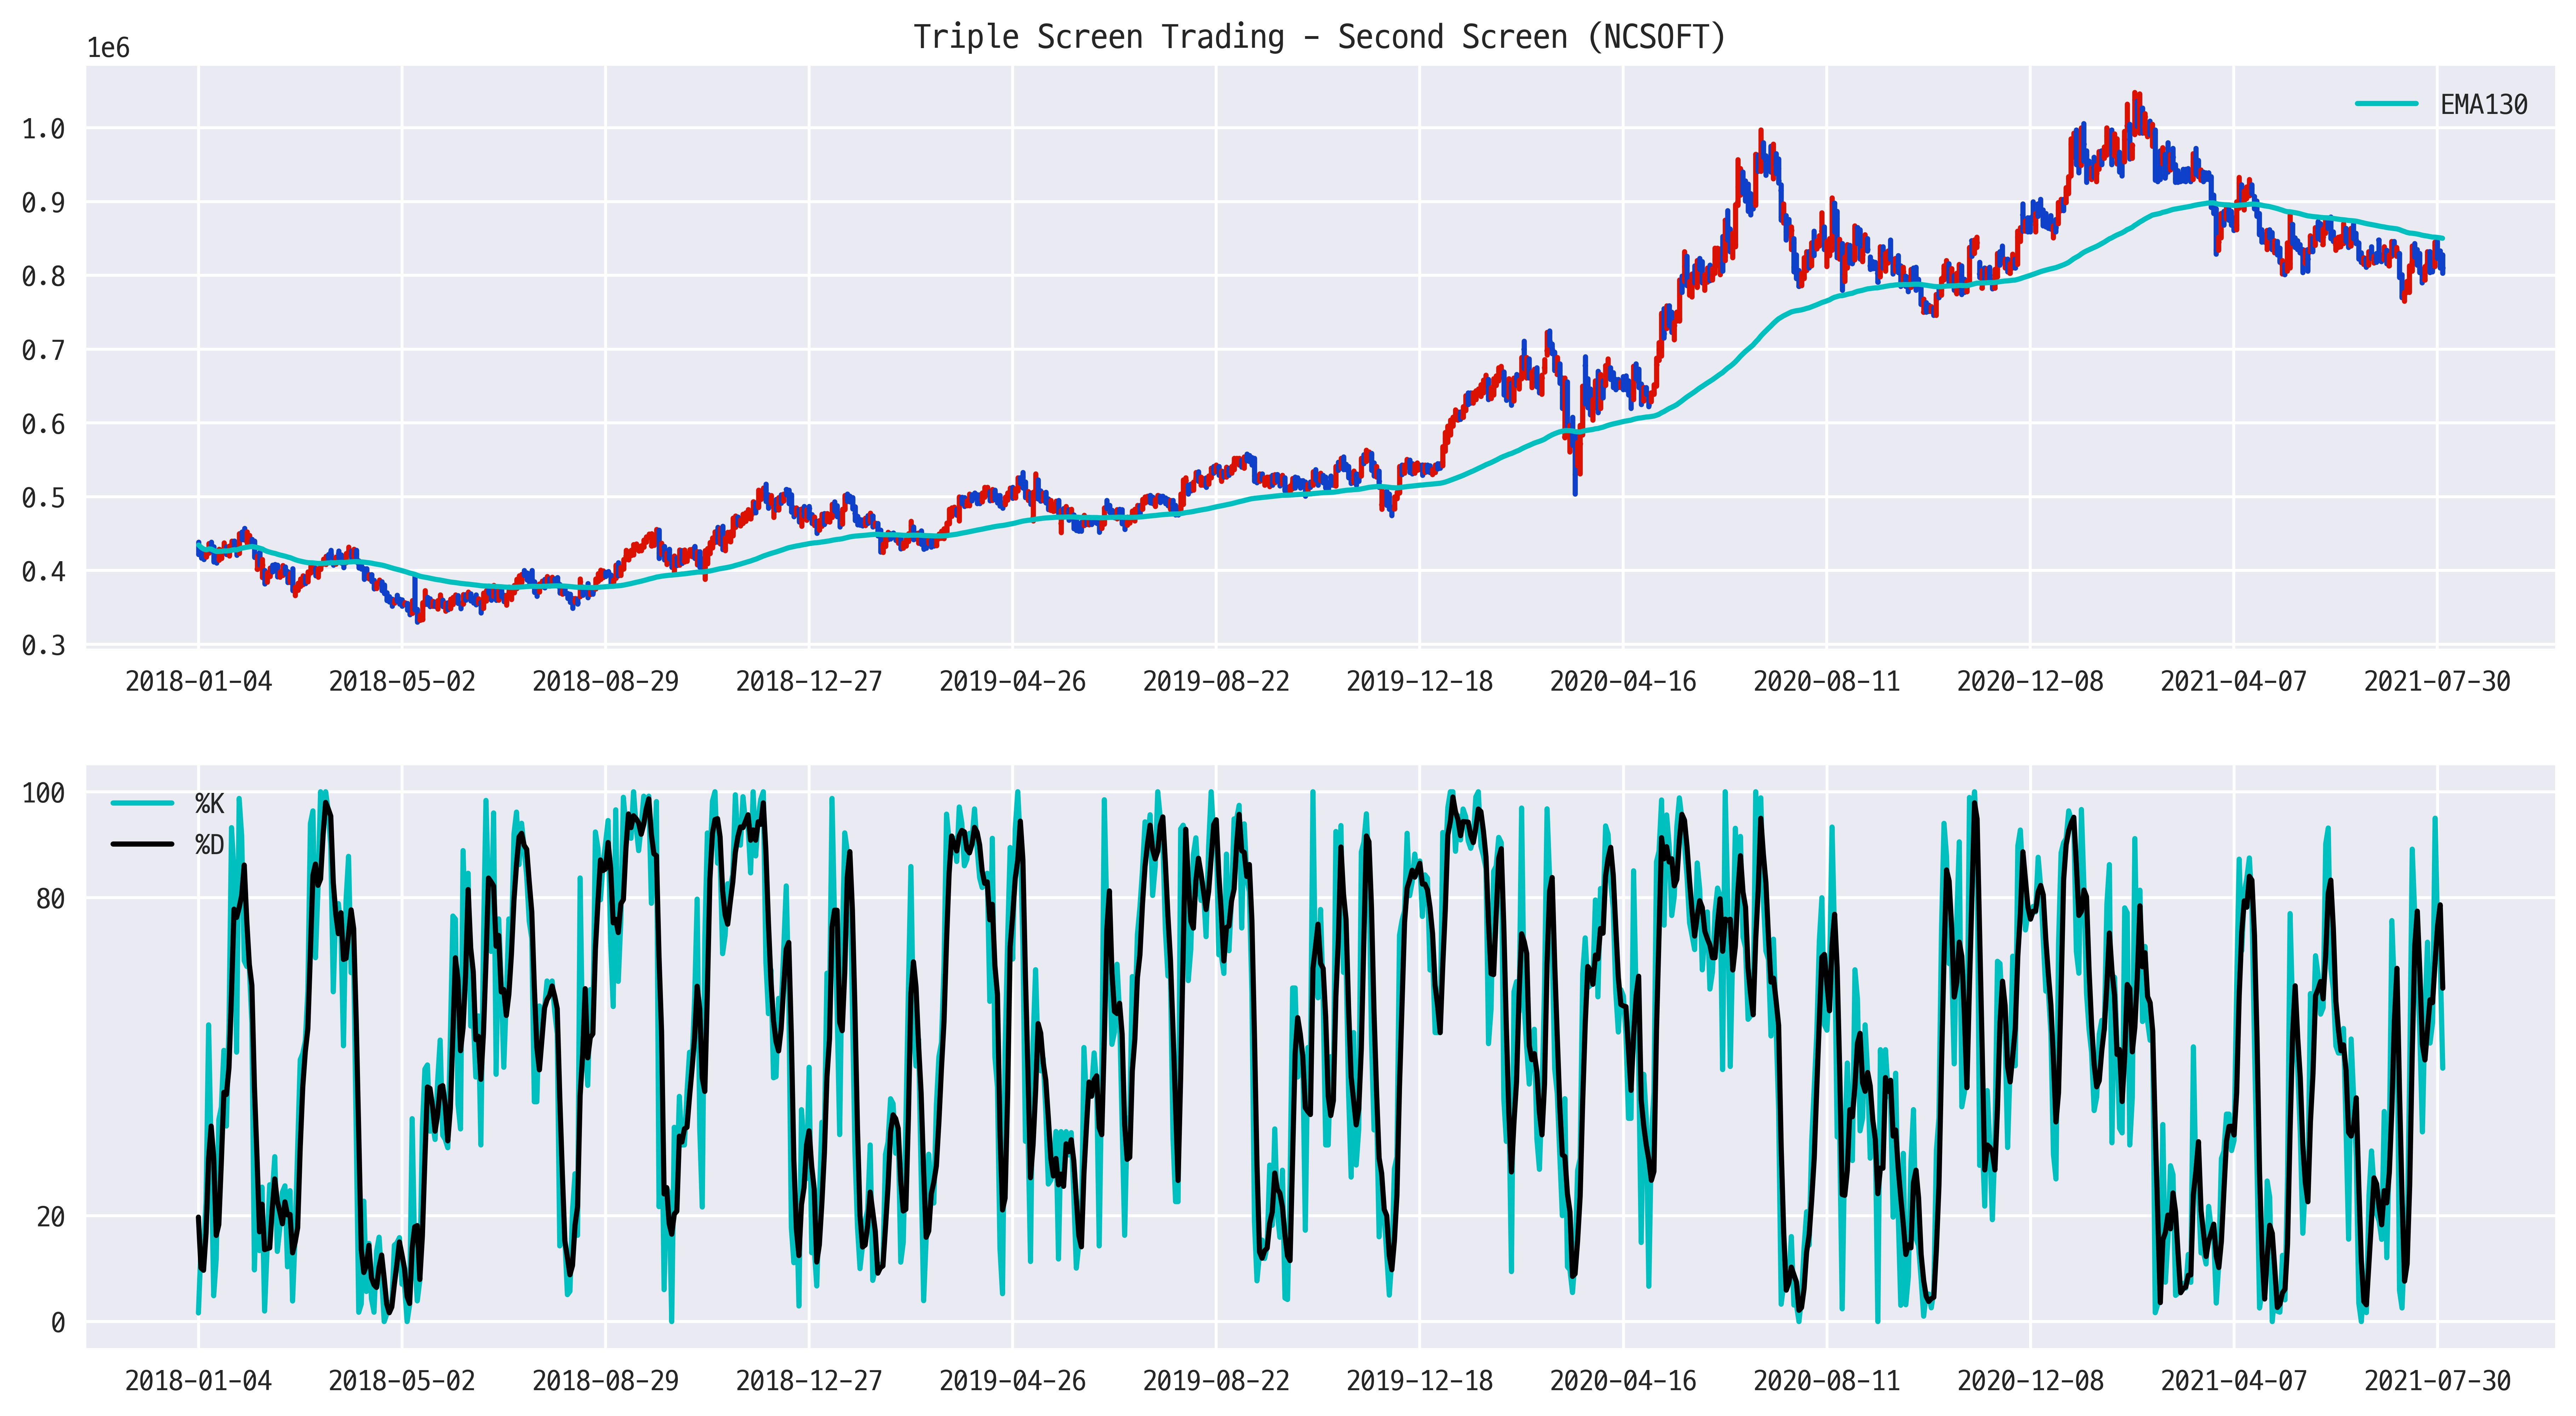

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (15.0, 8.0) # plt.figure(figsize=(16, 7))

# Chart 1 : OHLC Chart
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - Second Screen (NCSOFT)')
plt.grid(True)

# ohlc Chart 그리기
x = np.arange(0, len(ohlc))
for _, val in ohlc.iterrows():
    if val['close'] > val['open']: color = "#db1102" # 종가 상승
    else: color = "#0e40c9"                          # 종가 하락
    p1.plot([ x[_], x[_]], [val['low'], val['high']], color=color)     # High, Low Marker
    p1.plot([ x[_], x[_]-.1], [val['open'], val['open']], color=color) # Open Marker
    p1.plot([ x[_], x[_]+.1], [val['close'], val['close']], color=color) # close Marker

# ema130 Chart 추가하기
p1.plot(ohlc['ema130'], color='c', label='EMA130')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')

# Chart 2 : Signal Chart
p2 = plt.subplot(2, 1, 2)
plt.grid(True)
plt.plot(ohlc['fast_k'], color='c', label='%K')
plt.plot(ohlc['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100]) # 신호선 Y측 기준값을 정의한다
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')
plt.grid(True)
plt.show()

# **3 세 번째 창 - 진입기술 (Entry Technique)**
## **01 시장조류 & 시장파도 2개의 신호를 활용하여 매매시점 찾기**
- 스톡캐스틱 오실레이터를 활용하여 %D 를 활용한다
- 매매기준 포인트를 70, 30 대신에 80, 20을 활용하여 확실한 신호를 구분한다
- 매수시점 : 130일 이동지수평균 상승하고, $\%D$ 가 <span style="color:red">20</span> 아래로 떨어질 때
- 매도시점 : 이동지수평균 하락하고, $\%D$ 가 <span style="color:skyblue">80</span> 위로 올라깔 때 

| 주간추세  | 일간 오실레이터 |  행동  | 주문|
|:-------:|:------------:|:--------:|:------:|
|<span style="color:red">상승</span>| <span style="color:red">상승</span> | 관망 |  |
|<span style="color:red">상승</span>| <span style="color:skyblue">하락</span> | <span style="color:red">매수</span> | 추적매수 스톱 |
|<span style="color:skyblue">하락</span>| <span style="color:skyblue">하락</span> |관망 |  |
|<span style="color:skyblue">하락</span>| <span style="color:red">상승</span> | <span style="color:skyblue">매도</span> | 추적매도 스톱 |

In [9]:
ohlc = data_df.reset_index().copy()
ohlc.head(3)

Date    open    high     low   close  volume    change         ema130  \
0 2018-01-02  448000  452500  442000  446500  121955 -0.002235  446500.000000   
1 2018-01-03  441500  446500  432000  435000  234234 -0.025756  440705.769231   
2 2018-01-04  438500  438500  422000  422500  284220 -0.028736  434543.579022   

           ema60        macd     signal   macdhist  
0  446500.000000    0.000000   0.000000   0.000000  
1  440654.166667  -51.602564 -26.374644 -25.227920  
2  434399.962966 -143.616056 -67.204602 -76.411453

In [10]:
# 진입시점 오실레이터 추가
ema60    = ohlc.close.ewm(span=60).mean()
ema130   = ohlc.close.ewm(span=130).mean()
macd     = ema60 - ema130
signal   = macd.ewm(span=45).mean()
macdhist = macd - signal
ohlc     = ohlc.assign(
    ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist
).dropna()

ndays_high = ohlc.high.rolling(window=14, min_periods=1).max()
ndays_low  = ohlc.low.rolling(window=14, min_periods=1).min()

fast_k = (ohlc.close - ndays_low) / (ndays_high - ndays_low) * 100
slow_d = fast_k.rolling(window=3).mean()
ohlc = ohlc.assign(fast_k=fast_k, slow_d=slow_d).dropna()
ohlc = ohlc.reset_index(drop=True)
ohlc.head(3)

Date    open    high     low   close  volume    change         ema130  \
0 2018-01-04  438500  438500  422000  422500  284220 -0.028736  434543.579022   
1 2018-01-05  426500  430000  417000  422000  204527 -0.001183  431334.949229   
2 2018-01-08  422000  425000  415000  420000  143648 -0.004739  428997.673468   

           ema60        macd      signal    macdhist     fast_k     slow_d  
0  434399.962966 -143.616056  -67.204602  -76.411453   1.639344  19.710211  
1  431143.279645 -191.669585 -100.425299  -91.244286  14.084507  10.119333  
2  428763.612858 -234.060611 -129.579675 -104.480936  13.333333   9.685728

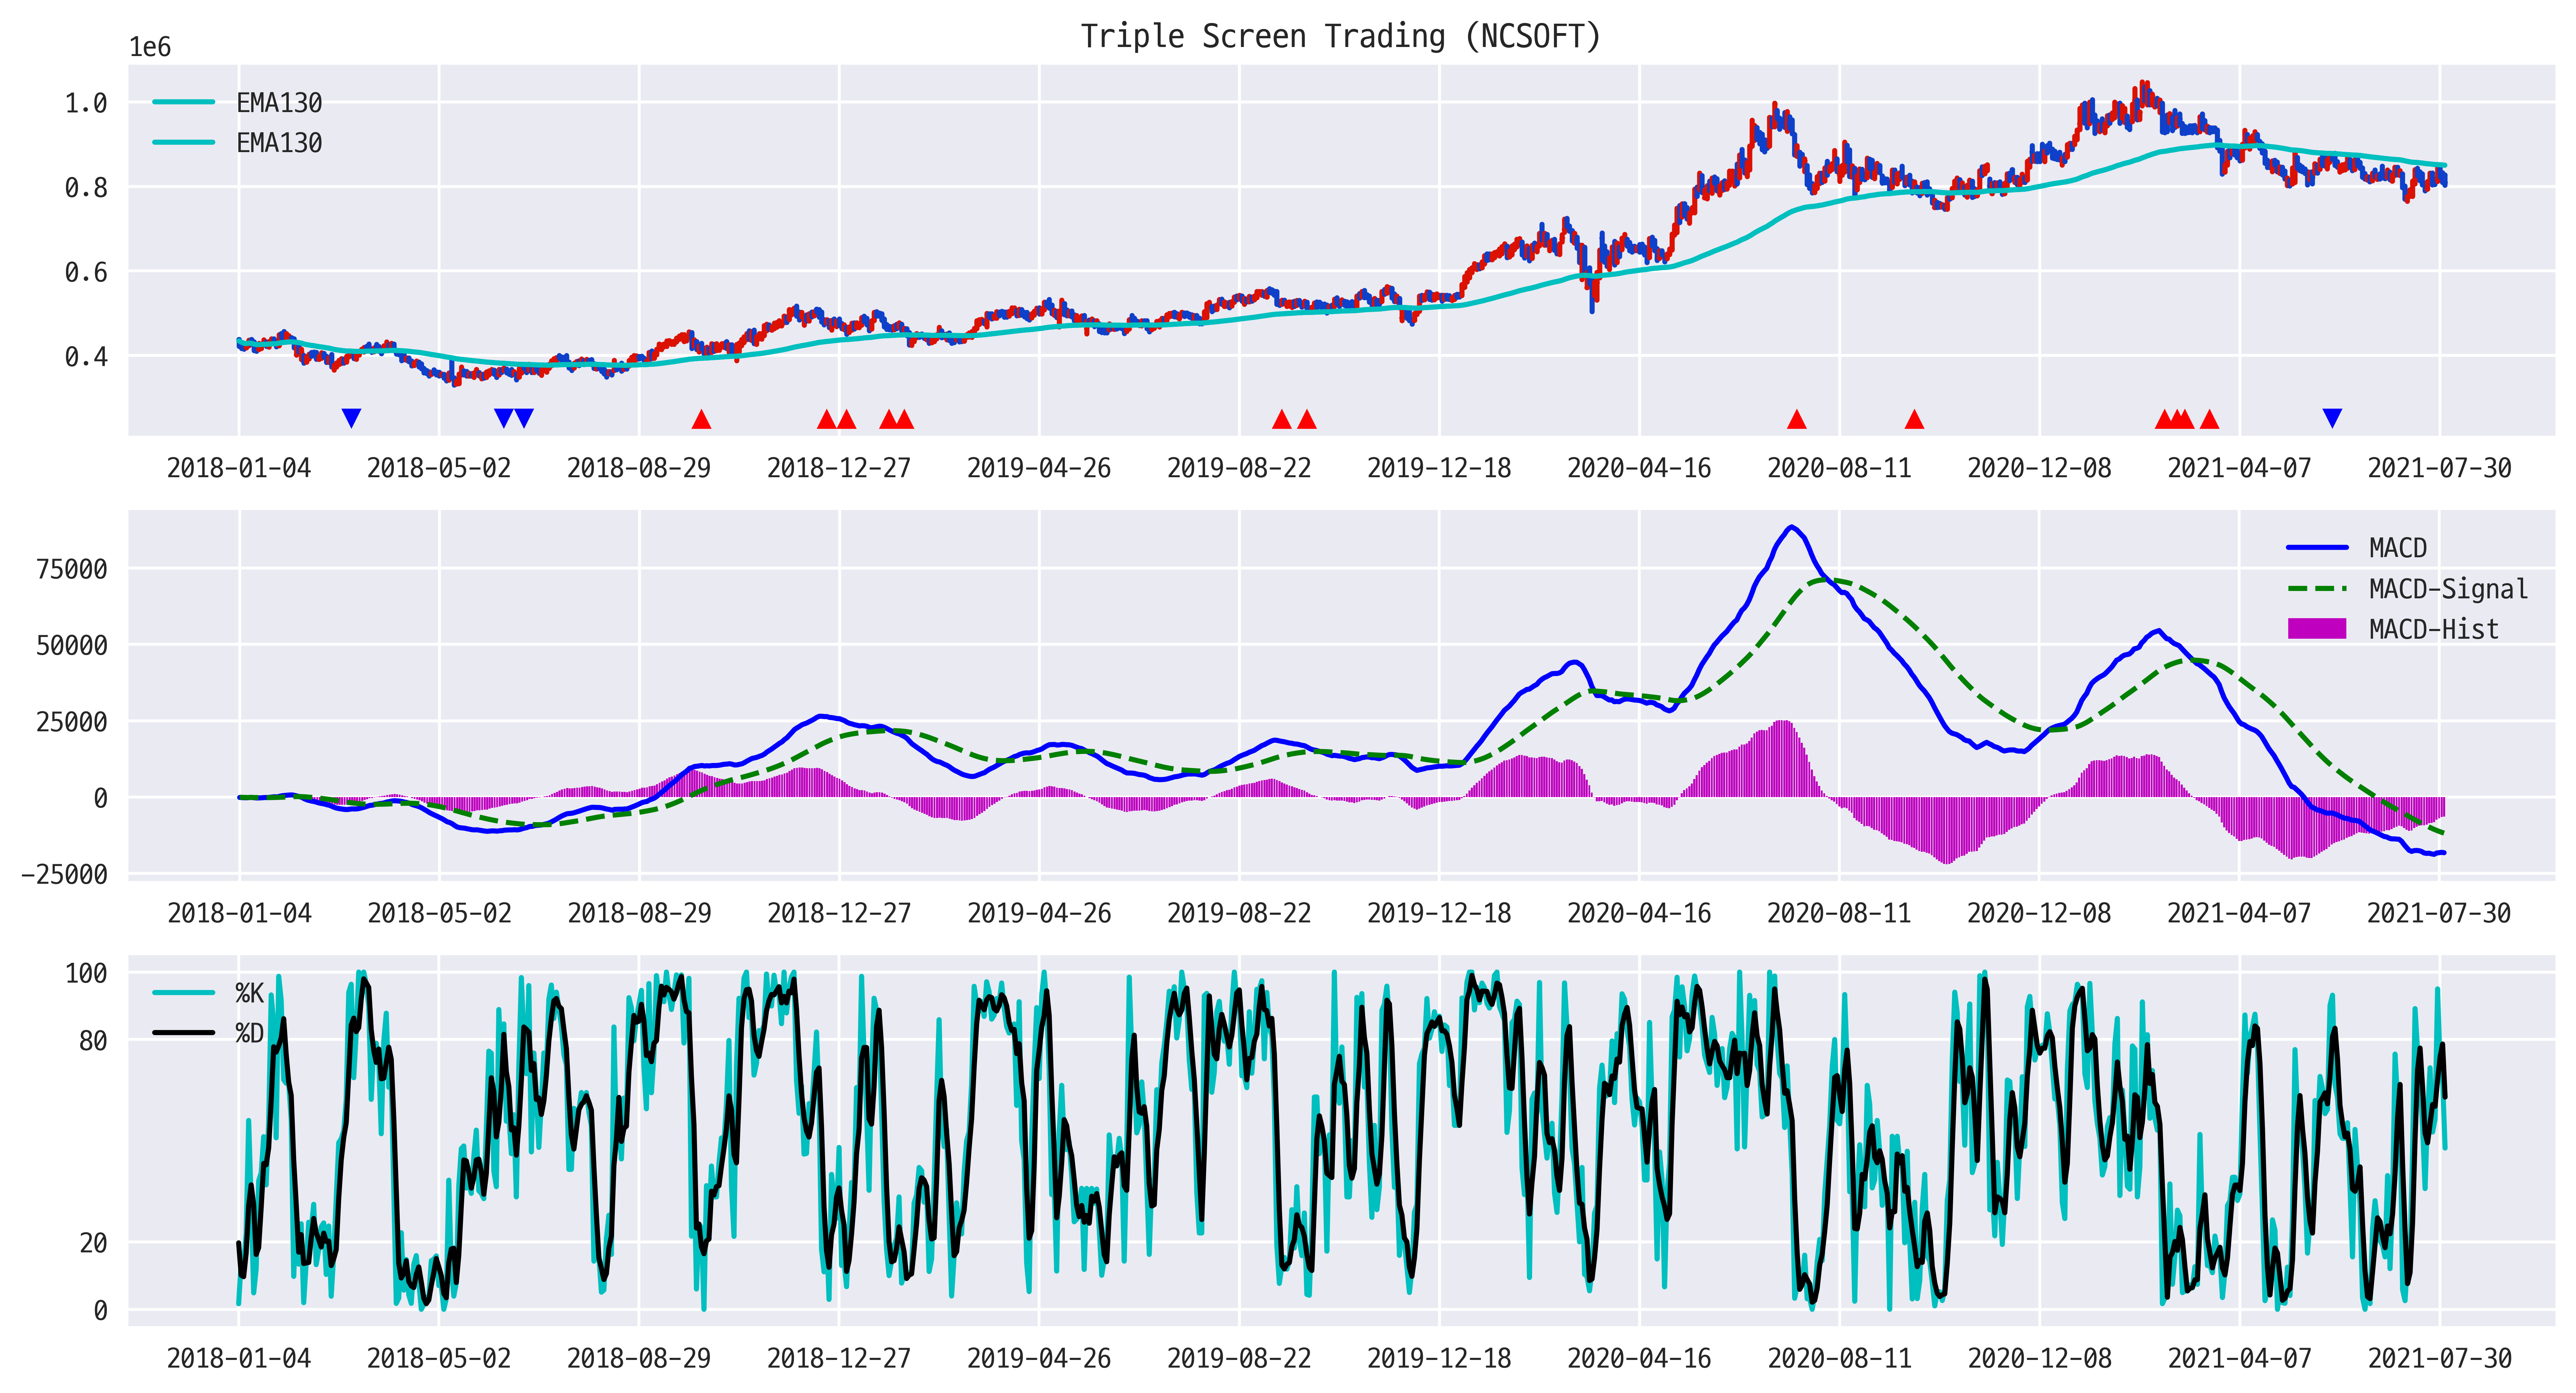

In [11]:
tick_steps = 80
# Chart 1 : OHLC Chart
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (15.0, 8.0) # plt.figure(figsize=(16, 9))
p1 = plt.subplot(3, 1, 1)
plt.title('Triple Screen Trading (NCSOFT)')
plt.grid(True)

# ohlc Chart 그리기
x = np.arange(0, len(ohlc))
for _, val in ohlc.iterrows():
    if val['close'] > val['open']: color = "#db1102" # 종가 상승
    else: color = "#0e40c9"                          # 종가 하락
    p1.plot([ x[_], x[_]], [val['low'], val['high']], color=color)     # High, Low Marker
    p1.plot([ x[_], x[_]-.1], [val['open'], val['open']], color=color) # Open Marker
    p1.plot([ x[_], x[_]+.1], [val['close'], val['close']], color=color) # close Marker

# ema130 Chart 추가하기
p1.plot(ohlc['ema130'], color='c', label='EMA130')
plt.xticks(x[::tick_steps], ohlc.Date.dt.date[::tick_steps])
plt.plot(ohlc['ema130'], color='c', label='EMA130')

for i in range(1, len(ohlc.close)):
    if ohlc.ema130.values[i-1] < ohlc.ema130.values[i] and \
        ohlc.slow_d.values[i-1] >= 20 and ohlc.slow_d.values[i] < 20:
        plt.plot(ohlc.index[i], 250000, 'r^') 
    elif ohlc.ema130.values[i-1] > ohlc.ema130.values[i] and \
        ohlc.slow_d.values[i-1] <= 80 and ohlc.slow_d.values[i] > 80:
        plt.plot(ohlc.index[i], 250000, 'bv')

plt.xticks(x[::tick_steps], ohlc.Date.dt.date[::tick_steps])
plt.legend(loc='best')

p2 = plt.subplot(3, 1, 2)
plt.grid(True)
plt.bar(ohlc.index, ohlc['macdhist'], color='m', label='MACD-Hist')
plt.plot(ohlc['macd'], color='b', label='MACD')
plt.plot(ohlc['signal'], 'g--', label='MACD-Signal')
plt.xticks(x[::tick_steps], ohlc.Date.dt.date[::tick_steps])
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
plt.grid(True)
plt.plot(ohlc['fast_k'], color='c', label='%K')
plt.plot(ohlc['slow_d'], color='k', label='%D')
plt.xticks(x[::tick_steps], ohlc.Date.dt.date[::tick_steps])
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')
plt.show()